<a href="https://colab.research.google.com/github/Dr-Schmoctor/sales-predictions/blob/main/Prediction_of_Product_Sales_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of Product Sales
- Author: Jeffrey Prichard


##Data Dictionary

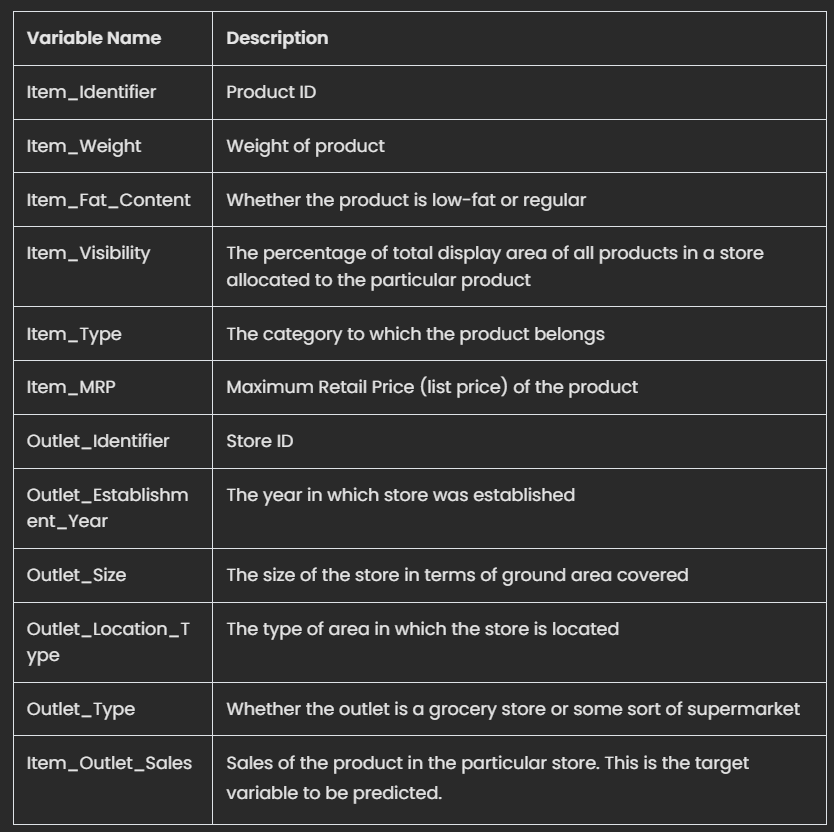

##Imports/Settings

In [74]:
## Pandas
import pandas as pd

## Numpy
import numpy as np

## MatPlotLib
import matplotlib.pyplot as plt

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

## Regression Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Set the default transformation output to Pandas
from sklearn import set_config

from IPython.core.display import clear_output

## Set global scikit-learn configuration
from sklearn import set_config

## Warnings
import warnings

In [75]:
## Set filter warnings to ignore
warnings.filterwarnings('ignore')

## Display all columns
pd.set_option('display.max_column', None)

## Display all rows
pd.set_option('display.max_rows', None)

In [76]:
## SK Learn Display
set_config(display='diagram')

## Transformers output as a Pandas Dataframe
set_config(transform_output='pandas')

##Functions

In [77]:
def regression_metrics(y_true, y_pred, label='', verbose=True, output_dict=False):

  """Helper Function
  This custom function accept true targets and predictions with custom label
  Calculate and print  MAE, MSE , RMSE and R2 scores by saving it in a dictionary"""

  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

In [78]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose=True,
                        output_frame=False, model_name=''):

  """This custom function accepts the model, X_train, y_train, X_test, and y_test
  Obtains the predictions from the model for both training and test data
  Inputs the true and predicted values into the helper function to obtain all the metrics for both the training and test data.
  Prints the results (optional with default as True
  Save the results as a dataframe (optional with default as False)"""

  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label= model_name + ' ' + 'Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label=model_name + ' ' + 'Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train, results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

#Load/Inspect Data

##Loading Data

In [79]:
#File location
file = "/content/drive/MyDrive/DataAnalytics/Project/sales_predictions_2023.csv"

#reading csv for dataframe and preview
df = pd.read_csv(file)
df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

##Inspecting Data

In [80]:
#INFO
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [81]:
#Number of Rows, Columns
df.shape

(8523, 12)

8523 Rows, 12 Columns

In [82]:
#DataType for Columns
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

All of the DataTypes are acceptable for the desired columns.

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


We can identify that two columns contain null values:
* Item_Weight
* Outlet_Size

In [84]:
df.describe(include="number")

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

In [85]:
df.describe(exclude="number")

Item_Identifier Item_Fat_Content              Item_Type  \
count             8523             8523                   8523   
unique            1559                5                     16   
top              FDW13          Low Fat  Fruits and Vegetables   
freq                10             5089                   1232   

       Outlet_Identifier Outlet_Size Outlet_Location_Type        Outlet_Type  
count               8523        6113                 8523               8523  
unique                10           3                    3                  4  
top               OUT027      Medium               Tier 3  Supermarket Type1  
freq                 935        2793                 3350               5577

#Clean Data

##Unneccessary Rows/Columns

Item Identifier
* This feature has a high cardinality and we can remove from the dataset.

In [86]:
df = df.drop(columns = ['Item_Identifier'])
df.head()

Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
0         9.30          Low Fat         0.016047                  Dairy   
1         5.92          Regular         0.019278            Soft Drinks   
2        17.50          Low Fat         0.016760                   Meat   
3        19.20          Regular         0.000000  Fruits and Vegetables   
4         8.93          Low Fat         0.000000              Household   

   Item_MRP Outlet_Identifier  Outlet_Establishment_Year Outlet_Size  \
0  249.8092            OUT049                       1999      Medium   
1   48.2692            OUT018                       2009      Medium   
2  141.6180            OUT049                       1999      Medium   
3  182.0950            OUT010                       1998         NaN   
4   53.8614            OUT013                       1987        High   

  Outlet_Location_Type        Outlet_Type  Item_Outlet_Sales  
0               Tier 1  Supermarket Type1          3735.1380  
1               Tier 3  Supermarket Type2           443.4228  
2               Tier 1  Supermarket Type1          2097.2700  
3               Tier 3      Grocery Store           732.3800  
4               Tier 3  Supermarket Type1           994.7052

##Duplicates

In [87]:
#duplicate filter
dup_rows = df.duplicated()
dup_rows

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68      False
69      False
70      False
71    

In [88]:
#Duplicate Count
df.duplicated().sum()

0

There are 0 Duplicated Rows and we do not need to remove any from our dataframe.

##Missing Values

We are using this data for Machine Learning. We will not Fill any missing values here, but we can view them.

In [89]:
#Convert the data to a Boolean detecting Nan
df.isna()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  Item_MRP  \
0           False             False            False      False     False   
1           False             False            False      False     False   
2           False             False            False      False     False   
3           False             False            False      False     False   
4           False             False            False      False     False   
5           False             False            False      False     False   
6           False             False            False      False     False   
7            True             False            False      False     False   
8           False             False            False      False     False   
9           False             False            False      False     False   
10          False             False            False      False     False   
11          False             False            False      False     False   
12          False             False            False      False     False   
13          False             False            False      False     False   
14          False             False            False      False     False   
15          False             False            False      False     False   
16          False             False            False      False     False   
17          False             False            False      False     False   
18           True             False            False      False     False   
19          False             False            False      False     False   
20          False             False            False      False     False   
21           True             False            False      False     False   
22          False             False            False      False     False   
23           True             False            False      False     False   
24          False             False            False      False     False   
25          False             False            False      False     False   
26          False             False            False      False     False   
27          False             False            False      False     False   
28          False             False            False      False     False   
29           True             False            False      False     False   
30          False             False            False      False     False   
31          False             False            False      False     False   
32          False             False            False      False     False   
33          False             False            False      False     False   
34          False             False            False      False     False   
35          False             False            False      False     False   
36           True             False            False      False     False   
37          False             False            False      False     False   
38           True             False            False      False     False   
39           True             False            False      False     False   
40          False             False            False      False     False   
41          False             False            False      False     False   
42          False             False            False      False     False   
43          False             False            False      False     False   
44          False             False            False      False     False   
45          False             False            False      False     False   
46          False             False            False      False     False   
47          False             False            False      False     False   
48          False             False            False      False     False   
49           True             False            False      False     False   
50          False             False            False      False     False   
51

In [90]:
#Total number of nul values for each column
null_sums = df.isna().sum()
null_sums

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We can establish that two columns need to be updated for null values:

* Item_Weight
* Outlet_Size

In [91]:
#We can visualize this information with misingno which we imported at the start
#msno.matrix(df);

##Inconsistent Data

In [92]:
#Lets break our columns into variables by data type
cat_cols = df.select_dtypes('object').columns

num_cols =df.select_dtypes('number').columns

###Categorical

In [93]:
#Now lets view our value_counts for all object columns
for col in cat_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  print('\n')

Value Counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64


Value Counts for Outlet_Size
Medium    2793
Small     2388
High       932
Name: Outlet_Size, 

Here we can identify that nearly all of our object types are correct without any errors. However, we can update both the errors of spelling in the Item_Fat_Content and the Outlet_Size of High to Large to fit with the small, medium and large theme.

In [94]:
#Item_Fat_Content
#Lets standardize our values
df["Item_Fat_Content"] = df["Item_Fat_Content"].replace({"LF":"Low Fat","low fat":"Low Fat","reg":"Regular"})
df["Item_Fat_Content"].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [95]:
#Outlet_Size
df["Outlet_Size"] = df["Outlet_Size"].replace({"High":"Large"})
df["Outlet_Size"].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

###Numerical

In [96]:
df.describe(include="number")

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

#Model Validation Split

Target: Item_Outlet_Sales

In [97]:
## Define features (X) and target (y)
target = 'Item_Outlet_Sales'
X = df.drop(columns = [target, 'Item_Outlet_Sales'])
y = df[target]

In [98]:
## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##Prepare Data

Datatypes for features:

* **Ordinal:** Outlet_Size
* **Nominal:** Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Location_Type, Outlet_Type
* **Numeric:** Item_Weight, Item_Visibility, Item_MRP, Outlet_Establishment_Year

##Ordinal Pipeline


In [99]:
# Prepare ordinal pipeline
ord_cols = ['Outlet_Size']

# Impute Most common
impute_common = SimpleImputer(strategy='most_frequent')

# Ordinal Encoder
shelf_order = ['Small','Medium','Large']
ord_encoder = OrdinalEncoder(categories=[shelf_order])

# Scaler
scaler = StandardScaler()

# make a pipeline
ord_pipe = make_pipeline(impute_common, ord_encoder, scaler)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                ('standardscaler', StandardScaler())])

In [100]:
ord_tuple = ("ordinal", ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'Large']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

##Nominal Pipeline

In [101]:
## Isolate categorical features
cat_cols = X_train.select_dtypes("object").drop(columns=ord_cols).columns
print("Categorical Features:", cat_cols)

## Instantiate the transformers
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(ohe)

## Define the categorical nominal tuple
cat_tuple = ('Categorical', ohe_pipe, cat_cols)

Categorical Features: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


##Numeric Pipeline

In [102]:
# Prepare numeric piepline
num_cols = X_train.select_dtypes('number').columns

mean_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

#Numeric Pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [103]:
num_tuple = ('Numeric', numeric_pipe, num_cols)
num_tuple

('Numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

##Column Transformer

In [104]:
preprocessor = ColumnTransformer([ord_tuple,
                                  num_tuple,
                                  cat_tuple],
                                  remainder='drop',
                                  verbose_feature_names_out=False)

In [105]:
# Fit on train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('Numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('Categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [106]:
# Transform the X_train and the X_test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

##Confirmation

In [107]:
##Confirmation
X_train_processed.head()

Outlet_Size  Item_Weight  Item_Visibility  Item_MRP  \
4776     0.287374     0.817249        -0.712775  1.828109   
7510     0.287374     0.556340        -1.291052  0.603369   
5828     0.287374    -0.131512         1.813319  0.244541   
5327    -1.384048    -1.169219        -1.004931 -0.952591   
4810     0.287374     1.528819        -0.965484 -0.336460   

      Outlet_Establishment_Year  Item_Fat_Content_Low Fat  \
4776                   1.327849                       1.0   
7510                   1.327849                       0.0   
5828                   0.136187                       0.0   
5327                   0.732018                       1.0   
4810                   0.493686                       1.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
4776                       0.0                     0.0               0.0   
7510                       1.0                     0.0               0.0   
5828                       1.0                     0.0               0.0   
5327                       0.0                     1.0               0.0   
4810                       0.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
4776                  0.0               0.0              0.0   
7510                  0.0               0.0              0.0   
5828                  0.0               0.0              0.0   
5327                  0.0               0.0              0.0   
4810                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
4776                     0.0                              0.0   
7510                     0.0                              0.0   
5828                     0.0                              0.0   
5327                     0.0                              0.0   
4810                     1.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
4776                    0.0                           0.0   
7510                    0.0                           0.0   
5828                    0.0                           0.0   
5327                    0.0                           0.0   
4810                    0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Others  \
4776                  1.0             0.0               0.0   
7510                  0.0             0.0               0.0   
5828                  0.0             1.0               0.0   
5327                  0.0             0.0               0.0   
4810                  0.0             0.0               0.0   

      Item_Type_Seafood  Item_Type_Snack Foods  Item_Type_Soft Drinks  \
4776                0.0                    0.0                    0.0   
7510                0.0                    1.0                    0.0   
5828                0.0                    0.0                    0.0   
5327                0.0                    0.0                    0.0   
4810                0.0                    0.0                    0.0   

      Item_Type_Starchy Foods  Outlet_Identifier_OUT010  \
4776                      0.0                       0.0   
7510                      0.0                       0.0   
5828                      0.0                       0.0   
5327                      0.0                       0.0   
4810                      0.0                       0.0   

      Outlet_Identifier_OUT013  Outlet_Identifier_OUT017  \
4776                       0.0                       0.0   
7510                       0.0                       0.0   
5828                       0.0                       0.0   
5327                       0.0                       0.0   
4810                       0.0                       0.0   

      Outlet_Identifier_OUT018  Outlet_Identifier_OUT019  \
4776                       1.0                       0.0   
7510              

In [108]:
X_train_processed.shape

(6392, 40)

In [109]:
X_test_processed.head()

Outlet_Size   Item_Weight  Item_Visibility  Item_MRP  \
7503     1.958796  3.310089e-01        -0.776646 -0.998816   
2957    -1.384048 -1.179892e+00         0.100317 -1.585194   
7031     0.287374  3.784469e-01        -0.482994 -1.595784   
1084     0.287374  4.213344e-16        -0.415440  0.506592   
856     -1.384048 -6.426567e-01        -1.047426  0.886725   

      Outlet_Establishment_Year  Item_Fat_Content_Low Fat  \
7503                  -1.293807                       1.0   
2957                  -0.102145                       1.0   
7031                   0.136187                       0.0   
1084                  -1.532139                       0.0   
856                    0.732018                       0.0   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
7503                       0.0                     0.0               0.0   
2957                       0.0                     0.0               0.0   
7031                       1.0                     0.0               0.0   
1084                       1.0                     0.0               0.0   
856                        1.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
7503                  0.0               0.0              0.0   
2957                  0.0               0.0              0.0   
7031                  0.0               1.0              0.0   
1084                  0.0               0.0              0.0   
856                   0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
7503                     1.0                              0.0   
2957                     0.0                              0.0   
7031                     0.0                              0.0   
1084                     0.0                              0.0   
856                      0.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
7503                    0.0                           0.0   
2957                    0.0                           1.0   
7031                    0.0                           0.0   
1084                    0.0                           0.0   
856                     0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Others  \
7503                  0.0             0.0               0.0   
2957                  0.0             0.0               0.0   
7031                  0.0             0.0               0.0   
1084                  0.0             0.0               0.0   
856                   0.0             1.0               0.0   

      Item_Type_Seafood  Item_Type_Snack Foods  Item_Type_Soft Drinks  \
7503                0.0                    0.0                    0.0   
2957                0.0                    0.0                    0.0   
7031                0.0                    0.0                    0.0   
1084                0.0                    0.0                    1.0   
856                 0.0                    0.0                    0.0   

      Item_Type_Starchy Foods  Outlet_Identifier_OUT010  \
7503                      0.0                       0.0   
2957                      0.0                       0.0   
7031                      0.0                       0.0   
1084                      0.0                       0.0   
856                       0.0                       0.0   

      Outlet_Identifier_OUT013  Outlet_Identifier_OUT017  \
7503                       1.0                       0.0   
2957                       0.0                       0.0   
7031                       0.0                       0.0   
1084                       0.0                       0.0   
856                        0.0                       0.0   

      Outlet_Identifier_OUT018  Outlet_Identifier_OUT019  \
7503                       0.0                       0.0   
2957        

In [110]:
X_test_processed.shape

(2131, 40)

In [111]:
X_train_processed.dtypes

Outlet_Size                        float64
Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Iden

In [112]:
X_test_processed.dtypes

Outlet_Size                        float64
Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Iden

In [113]:
# check null values
X_train_processed.isna().sum().sum()

0

In [114]:
# check null values
X_test_processed.isna().sum().sum()

0

#Modeling

##Baseline

In [115]:
## Create an instance of the model
dummy = DummyRegressor(strategy='mean')

## Create a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

## Fit the model
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('sta...
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('dummyregressor', DummyRegressor())])

###metrics

In [116]:
## Model predictions
train_preds = dummy_pipe.predict(X_train)
test_preds = dummy_pipe.predict(X_test)

## Inspect the first (5) predictions
train_preds[:5]

array([2209.9793572, 2209.9793572, 2209.9793572, 2209.9793572,
       2209.9793572])

In [117]:
## Check predictions against features
print('First Row of X_train')
display(X_train.iloc[0])

print('\nPredicted Item_Outlet_Sales:')
display(train_preds[0])

First Row of X_train


Item_Weight                              16.35
Item_Fat_Content                       Low Fat
Item_Visibility                       0.029565
Item_Type                            Household
Item_MRP                              256.4646
Outlet_Identifier                       OUT018
Outlet_Establishment_Year                 2009
Outlet_Size                             Medium
Outlet_Location_Type                    Tier 3
Outlet_Type                  Supermarket Type2
Name: 4776, dtype: object


Predicted Item_Outlet_Sales:


2209.9793571964956

In [118]:
## Display model performance metrics using a function
dummy_metrics = evaluate_regression(dummy_pipe, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=True, model_name = 'Baseline Dummy')

dummy_metrics

------------------------------------------------------------
Regression Metrics: Baseline Dummy Training Data
------------------------------------------------------------
- MAE = 1,360.218
- MSE = 2,959,455.705
- RMSE = 1,720.307
- R^2 = 0.000

------------------------------------------------------------
Regression Metrics: Baseline Dummy Test Data
------------------------------------------------------------
- MAE = 1,326.121
- MSE = 2,772,144.463
- RMSE = 1,664.976
- R^2 = -0.005


MAE          MSE      RMSE    R^2
Baseline Dummy Training Data  1360.218  2959455.705  1720.307  0.000
Baseline Dummy Test Data      1326.121  2772144.463  1664.976 -0.005

##Linear Regression Model

In [119]:
## Create an instance of the model
lin_reg = LinearRegression()
## Create a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

## Fit the model
lin_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('sta...
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

###metrics

In [120]:
lin_reg_metrics = evaluate_regression(lin_reg_pipe, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=True, model_name = 'Linear model')

metrics = pd.concat([dummy_metrics, lin_reg_metrics])
metrics

------------------------------------------------------------
Regression Metrics: Linear model Training Data
------------------------------------------------------------
- MAE = 848.194
- MSE = 1,298,814.122
- RMSE = 1,139.655
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Linear model Test Data
------------------------------------------------------------
- MAE = 807.189
- MSE = 1,199,635.872
- RMSE = 1,095.279
- R^2 = 0.565


MAE          MSE      RMSE    R^2
Baseline Dummy Training Data  1360.218  2959455.705  1720.307  0.000
Baseline Dummy Test Data      1326.121  2772144.463  1664.976 -0.005
Linear model Training Data     848.194  1298814.122  1139.655  0.561
Linear model Test Data         807.189  1199635.872  1095.279  0.565

##Random Forest Model

In [121]:
from sklearn.ensemble import RandomForestRegressor

In [122]:
## Create an instance of the model
rf = RandomForestRegressor()

## Create a model pipeline
rf_pipe = make_pipeline(preprocessor, rf)

## Fit the model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('Numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('sta...
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('Categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor', RandomForestRegressor())])

###metrics

In [123]:
## Display model performance metrics using a function

rf_metrics = evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test,
                    model_name='RandomForest', output_frame=True)

## Concatenate metrics to metrics dataframe

metrics = pd.concat([metrics, rf_metrics])
metrics

------------------------------------------------------------
Regression Metrics: RandomForest Training Data
------------------------------------------------------------
- MAE = 294.984
- MSE = 180,145.417
- RMSE = 424.435
- R^2 = 0.939

------------------------------------------------------------
Regression Metrics: RandomForest Test Data
------------------------------------------------------------
- MAE = 772.595
- MSE = 1,229,256.154
- RMSE = 1,108.718
- R^2 = 0.554


MAE          MSE      RMSE    R^2
Baseline Dummy Training Data  1360.218  2959455.705  1720.307  0.000
Baseline Dummy Test Data      1326.121  2772144.463  1664.976 -0.005
Linear model Training Data     848.194  1298814.122  1139.655  0.561
Linear model Test Data         807.189  1199635.872  1095.279  0.565
RandomForest Training Data     294.984   180145.417   424.435  0.939
RandomForest Test Data         772.595  1229256.154  1108.718  0.554

###tuning

In [124]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categories=[['Small',
                                                                                 'Medium',
                                                                                 'Large']])),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    ['Outlet_Size']),
                                   ('Numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
     

In [127]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [5,6,7,8,9,10,11,12,13,14,15],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

In [128]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 792 candidates, totalling 2376 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder(categories=[['Small',
                                                                                                                      'Medium',
                                                                                                                      'Large']])),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Outlet_Size']),
                                                                        ('Numeric',
                                                                         Pipeline(steps=[('simpleimp...
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [5, 6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                                              15],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [129]:
# Obtain best parameters
gridsearch.best_params_

{'randomforestregressor__max_depth': 5,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 2,
 'randomforestregressor__n_estimators': 200,
 'randomforestregressor__oob_score': False}

In [130]:
best_rf = gridsearch.best_estimator_

evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics:  Training Data
------------------------------------------------------------
- MAE = 755.293
- MSE = 1,152,694.395
- RMSE = 1,073.636
- R^2 = 0.611

------------------------------------------------------------
Regression Metrics:  Test Data
------------------------------------------------------------
- MAE = 728.033
- MSE = 1,093,835.119
- RMSE = 1,045.866
- R^2 = 0.604


##Model Comparison

In [134]:
rf_metrics = evaluate_regression(best_rf, X_train, y_train, X_test, y_test,
                                 model_name='Tuned RF', output_frame=True)

metrics = pd.concat([metrics, rf_metrics])
metrics

------------------------------------------------------------
Regression Metrics: Tuned RF Training Data
------------------------------------------------------------
- MAE = 755.293
- MSE = 1,152,694.395
- RMSE = 1,073.636
- R^2 = 0.611

------------------------------------------------------------
Regression Metrics: Tuned RF Test Data
------------------------------------------------------------
- MAE = 728.033
- MSE = 1,093,835.119
- RMSE = 1,045.866
- R^2 = 0.604


MAE          MSE      RMSE    R^2
Baseline Dummy Training Data  1360.218  2959455.705  1720.307  0.000
Baseline Dummy Test Data      1326.121  2772144.463  1664.976 -0.005
Linear model Training Data     848.194  1298814.122  1139.655  0.561
Linear model Test Data         807.189  1199635.872  1095.279  0.565
RandomForest Training Data     294.984   180145.417   424.435  0.939
RandomForest Test Data         772.595  1229256.154  1108.718  0.554
Tuned RF Training Data         755.293  1152694.395  1073.636  0.611
Tuned RF Test Data             728.033  1093835.119  1045.866  0.604

It appears our Random Forest is a better model to utilize after the tuning.

1. The stakeholders can be confident in this analysis because our R2 value for the Training (.611) AND Test (.604) data are strong.
2. this model is also not underfit or overfit for our data. Compared to our first Random Forest model, which was overfit for our Training Data, this model shows a much closer R2 for both Training/Test and also has a similar RMSE on both.

The RMSE was also the best on our Tuned Random Forest model. It was a smaller error than our Linear or RandomForest model on the Test data.